<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/ViT_FocalMarginLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective of the Notebook
### This notebook fine-tunes a Vision Transformer model on the Flowers102 dataset using FocalMarginLoss, early stopping, and visualizes training and validation metrics, concluding with test accuracy evaluation

In [61]:
# necessary imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102

In [62]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images to 224x224 pixels
    transforms.ToTensor(),  # convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize using ImageNet mean and std
])

In [63]:
train_data = Flowers102(root='./data', split='train', transform=transform, download=True)  # load training set of Flowers102 dataset with specified transformations
val_data = Flowers102(root='./data', split='val', transform=transform, download=True)  # load validation set of Flowers102 dataset with transformations
test_data = Flowers102(root='./data', split='test', transform=transform, download=True)  # load test set of Flowers102 dataset with transformations

In [64]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)  # create data loader for training set, with batch size 16 and shuffling enabled
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)  # create data loader for validation set, with batch size 16 and no shuffling
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)  # create data loader for test set, with batch size 16 and no shuffling

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device

In [66]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=102)  
# load a pre-trained Vision Transformer (ViT) model fine-tuned for image classification with 102 output labels (for Flowers102 dataset)

model = model.to(device)  # move the model to the specified device (CPU or GPU)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### We designed FocalMarginLoss as a custom loss function that combines focal loss and margin loss to improve model performance, particularly in imbalanced classification tasks. Focal loss emphasizes hard-to-classify samples by scaling the loss for misclassified examples, while margin loss enforces a separation between classes by applying a margin to the logits of correct classes. This dual approach enables our model to focus on difficult cases and enhances class discrimination, promoting improved accuracy and robustness against class imbalance

In [67]:
class FocalMarginLoss(nn.Module):
    def __init__(self, gamma=1, alpha=0.5, margin=0.4, lambda_margin=0.5):
        # initialize FocalMarginLoss, inheriting from nn.Module
        # gamma: focusing parameter for focal loss
        # alpha: scaling factor for the positive class in focal loss
        # margin: margin to be subtracted from logits for margin loss
        # lambda_margin: weight for margin loss component
        super(FocalMarginLoss, self).__init__()
        
        self.gamma = gamma  # focusing parameter to adjust the strength of focal loss
        self.alpha = alpha  # balancing factor for focal loss, applied to the positive class
        self.margin = margin  # margin to be applied to the correct class in logits for margin loss
        self.lambda_margin = lambda_margin  # weight applied to margin loss in the final loss calculation
        self.ce_loss = nn.CrossEntropyLoss()  # standard cross-entropy loss for margin loss calculation

    def forward(self, logits, targets):
        # define the forward pass for the loss function
        # logits: raw model outputs for each class
        # targets: ground truth class labels
        
        # calculate log-probabilities for each class using softmax and log functions
        log_prob = F.log_softmax(logits, dim=-1)  # apply log softmax to logits
        prob = torch.exp(log_prob)  # convert log-probabilities back to probabilities
        
        # calculate focal loss
        # focal loss formula: -alpha * (1 - prob) ^ gamma * log_prob
        # this focuses the loss more on hard-to-classify samples
        focal_loss = -self.alpha * (1 - prob) ** self.gamma * log_prob  # focal loss component
        # select only the focal loss values corresponding to the correct class and compute the mean
        focal_loss = focal_loss.gather(1, targets.unsqueeze(1)).mean()  # mean focal loss for the batch

        # calculate margin loss
        # create a copy of logits to apply margin modification
        margin_logit = logits.clone()  
        # subtract the margin from the logits of the correct class to enforce a separation from other classes
        margin_logit[range(len(targets)), targets] -= self.margin  
        # calculate cross-entropy loss on modified logits, encouraging a margin from the correct class
        margin_loss = self.ce_loss(margin_logit, targets)  # compute margin loss with modified logits

        # return the combined loss
        # focal loss emphasizes hard samples; margin loss enforces a distance margin for correct classes
        return focal_loss + self.lambda_margin * margin_loss  # final loss as a combination of focal and margin losses

# create an instance of the FocalMarginLoss criterion with default parameters
criterion = FocalMarginLoss()


In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)  # initialize Adam optimizer with a learning rate of 2e-5 

In [69]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        # initialize EarlyStopping class
        # patience: number of epochs to wait before stopping if no improvement
        # verbose: whether to print information about early stopping
        self.patience = patience  # how many epochs to wait for improvement
        self.verbose = verbose  # whether to print detailed info
        self.counter = 0  # counter for epochs without improvement
        self.best_score = None  # best score seen so far
        self.early_stop = False  # flag to indicate whether to stop early

    def __call__(self, score, epoch):
        # call method to check if early stopping should be triggered
        if self.best_score is None:
            # if no best score yet, set current score as the best
            self.best_score = score
        elif score < self.best_score:
            # if the current score is worse than the best score
            self.counter += 1  # increment the counter for no improvement
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience} at epoch {epoch}')
            if self.counter >= self.patience:
                # if the counter reaches patience limit, trigger early stopping
                self.early_stop = True
                print(f'Early stopping at epoch {epoch}. No improvement in validation accuracy for {self.patience} consecutive epochs.')
        else:
            # if the current score is better, update best score and reset counter
            self.best_score = score
            self.counter = 0


In [70]:
def train_model(model, train_loader, val_loader, optimizer, criterion, model_save_path, epochs=5, patience=5):
    # initialize early stopping with specified patience and verbosity
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_val_accuracy = 0.0  # track the best validation accuracy
    best_model_wts = None  # store the best model weights

    # lists to store loss and accuracy history
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        model.train()  # set model to training mode
        running_loss = 0.0  # cumulative loss for the epoch
        correct = 0  # count of correct predictions
        total = 0  # total number of samples

        # iterate over training data batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # move data to device

            optimizer.zero_grad()  # reset gradients
            outputs = model(images).logits  # forward pass to get outputs
            loss = criterion(outputs, labels)  # compute loss
            loss.backward()  # backward pass to compute gradients
            optimizer.step()  # update model weights

            running_loss += loss.item()  # accumulate loss

            _, predicted = torch.max(outputs, 1)  # get predictions
            total += labels.size(0)  # update total samples count
            correct += (predicted == labels).sum().item()  # update correct predictions count

        train_loss = running_loss / len(train_loader)  # average training loss
        train_accuracy = correct / total  # training accuracy

        # validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)

        # save metrics for each epoch
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        # print metrics for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")

        # update best model weights if validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()

        # check if early stopping condition is met
        early_stopping(val_accuracy, epoch + 1)
        if early_stopping.early_stop:
            break  # stop training if no improvement in validation accuracy

    # load the best model weights if available
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # save the best model to the specified path
    torch.save(model.state_dict(), model_save_path)

    # return loss and accuracy history 
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


In [71]:
def validate_model(model, val_loader, criterion):
    model.eval()  # set model to evaluation mode
    total_loss = 0.0  # variable to accumulate total loss
    correct = 0  # count of correct predictions
    total = 0  # total number of samples

    # disable gradient computation for validation
    with torch.no_grad():
        # iterate over validation data batches
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # move data to device
            outputs = model(images).logits  # forward pass to get outputs
            loss = criterion(outputs, labels)  # compute loss

            total_loss += loss.item()  # accumulate loss

            _, predicted = torch.max(outputs, 1)  # get predicted labels
            total += labels.size(0)  # update total samples count
            correct += (predicted == labels).sum().item()  # count correct predictions

    # calculate average validation loss
    val_loss = total_loss / len(val_loader)
    # calculate validation accuracy
    val_accuracy = correct / total
    return val_loss, val_accuracy  # return validation loss and accuracy

In [72]:
def test_model(model, test_loader):
    model.eval()  # set model to evaluation mode
    correct = 0  # count of correct predictions
    total = 0  # total number of samples

    # disable gradient computation for testing
    with torch.no_grad():
        # iterate over test data batches
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # move data to device
            outputs = model(images).logits  # forward pass to get outputs
            _, predicted = torch.max(outputs, 1)  # get predicted labels

            total += labels.size(0)  # update total samples count
            correct += (predicted == labels).sum().item()  # count correct predictions

    # print test accuracy as a percentage
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [73]:
# Train the model and save best weights, returning loss and accuracy history
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=25, model_save_path='Best_ViT_FocalMarginLoss.pth')

Epoch [1/25], Train Loss: 4.7348, Train Accuracy: 0.0814, Validation Loss: 4.6319, Validation Accuracy: 0.2078
Epoch [2/25], Train Loss: 4.4863, Train Accuracy: 0.5020, Validation Loss: 4.4407, Validation Accuracy: 0.6108
Epoch [3/25], Train Loss: 4.2237, Train Accuracy: 0.8873, Validation Loss: 4.2412, Validation Accuracy: 0.7902
Epoch [4/25], Train Loss: 3.9569, Train Accuracy: 0.9755, Validation Loss: 4.0558, Validation Accuracy: 0.8588
Epoch [5/25], Train Loss: 3.7041, Train Accuracy: 0.9922, Validation Loss: 3.8779, Validation Accuracy: 0.8882
Epoch [6/25], Train Loss: 3.4612, Train Accuracy: 0.9990, Validation Loss: 3.7104, Validation Accuracy: 0.9127
Epoch [7/25], Train Loss: 3.2395, Train Accuracy: 0.9980, Validation Loss: 3.5603, Validation Accuracy: 0.9137
Epoch [8/25], Train Loss: 3.0279, Train Accuracy: 1.0000, Validation Loss: 3.4085, Validation Accuracy: 0.9294
Epoch [9/25], Train Loss: 2.8281, Train Accuracy: 1.0000, Validation Loss: 3.2668, Validation Accuracy: 0.9392
E

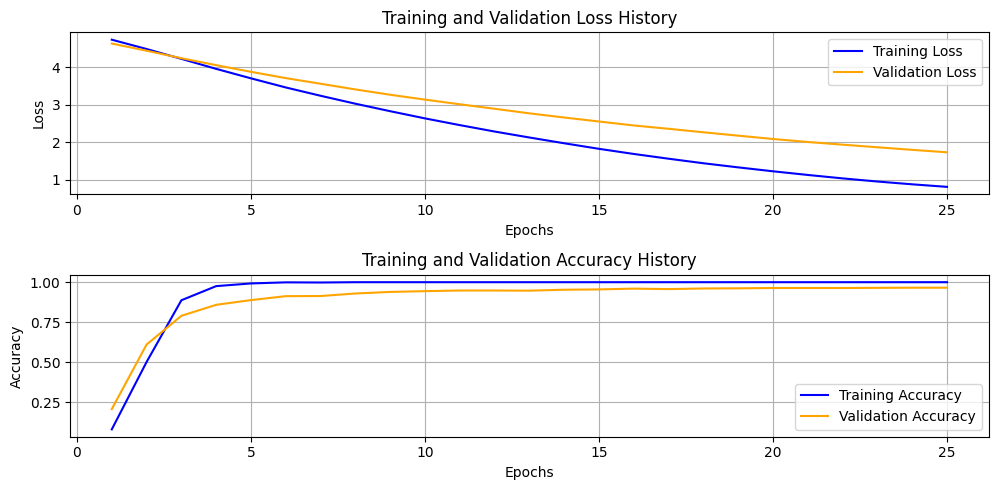

In [76]:
# cell for plotting training and validation metrics
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [77]:
# evaluate best model on test dataset
test_model(model, test_loader)

Test Accuracy: 95.10%


## Analysis of Results
### The training and validation loss consistently decreased over 25 epochs, indicating steady learning and no overfitting. The training and validation accuracy closely converged, ultimately reaching a high test accuracy of 95.10%, suggesting effective generalization and model performance on the Flowers102 dataset.